In [1]:
import tensorflow as tf
from ASR_Network import ASR_Network
from DataPipe import DataPipeFactory
from util_function import inform_pooling, AndMasking
import coremltools as ct

Using TensorFlow backend


scikit-learn version 1.3.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.
TensorFlow version 2.15.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


In [2]:
# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [3]:
ds = DataPipeFactory('../DataFolder/Tensorflow_DataRecord/Student_Answer_Record_Eval.tfrecord',
                     '../DataFolder/Siri_Related/Siri_Reference_Sample',
                     '../DataFolder/Siri_Related/Siri_Dense_Index', cache='../DataFolder/cache/datapipe/cached')
# dsp = ds.get_batch_data(10)
# it = iter(dsp)
ds.get_raw_data()

<_PrefetchDataset element_spec={'stu_mfcc': TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), 'ref_mfcc': TensorSpec(shape=(4, None, 80), dtype=tf.float32, name=None), 'valid_stu_start': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'valid_stu_duration': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'valid_ref_word': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'valid_ref_start': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'valid_ref_duration': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'RecordName': TensorSpec(shape=<unknown>, dtype=tf.string, name=None), 'passage_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'MatchSegment': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'MatchReference': TensorSpec(shape=(4, None), dtype=tf.int64, name=None)}>

In [4]:
base_feature = ([None, 80], 128, [128, 192, 256, 384], 3, 2)
base_feature_name = ('input_shape', 'feature_depth', 'channels_list', 'filter_size', 'stack_size')
dense_feature = ([704], 32, [256, 128], 2)
dense_feature_name = ('input_shape', 'output_shape', 'channels_list', 'stack_size')
word_prediction = ([32], 1800, [128, 128], 1)
word_prediction_name = ('input_shape', 'output_shape', 'channels_list', 'stack_size')
# Generate dict using zip
# base_feature = dict(zip(base_feature_name, base_feature))
# dense_feature = dict(zip(dense_feature_name, dense_feature))
# word_prediction = dict(zip(word_prediction_name, word_prediction))
base_ratio = 125
hyper_para = {'base_feature': dict(zip(base_feature_name, base_feature)),
              'dense_feature': dict(zip(dense_feature_name, dense_feature)),
              'word_prediction': dict(zip(word_prediction_name, word_prediction)),
              'base_ratio': base_ratio,
              'batch_num': 2,
              'margin': 0.4,
}
C = ASR_Network(**hyper_para)

In [5]:
Cin = C.base_network.input
Cin1 = tf.keras.Input(shape=[None])
Cin2 =  tf.keras.Input(shape=[None])

In [6]:
Cout = C([Cin,[Cin1, Cin2]])

In [7]:
CFull = tf.keras.Model(inputs=[Cin, [Cin1, Cin2]], outputs=Cout)

In [11]:
R = ct.convert(CFull, source="tensorflow", convert_to="mlprogram")

AttributeError: 'RaggedTensor' object has no attribute 'name'

In [17]:
def unpack(d):
    value_s = d['stu_mfcc']
    start_s = tf.RaggedTensor.from_tensor(d['valid_stu_start'], padding=-1.)
    duration_s = tf.RaggedTensor.from_tensor(d['valid_stu_duration'], padding=-1.)

    # unpack with another key ref_mfcc, valid_ref_start, valid_ref_duration
    value_f = d['ref_mfcc']
    # The previous padding value is shift to -13.815510749816895, reset to -1
    value_f = tf.where(tf.equal(value_f, -13.815510749816895), -1., value_f)
    start_f = tf.RaggedTensor.from_tensor(d['valid_ref_start'], padding=-1.)
    duration_f = tf.RaggedTensor.from_tensor(d['valid_ref_duration'], padding=-1.)

    # unpack valid_ref_word
    words = tf.RaggedTensor.from_tensor(d['valid_ref_word'], padding=-1)
    return ((value_s, (start_s, duration_s)), (value_f, (start_f, duration_f))), words

In [18]:
dst = ds.get_batch_data(2, addition_map=unpack)

In [19]:
dst

<_PrefetchDataset element_spec=(((TensorSpec(shape=(2, None, 80), dtype=tf.float32, name=None), (RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64), RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64))), (TensorSpec(shape=(2, None, 80), dtype=tf.float32, name=None), (RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64), RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64)))), RaggedTensorSpec(TensorShape([2, None]), tf.int64, 1, tf.int64))>

In [20]:
it = iter(dst)

In [21]:
data = next(it)

In [10]:
def call(self, inputs, training=False, mask=None):
    audio, (start, duration) = inputs
    # compute the base network
    base_output, maps = self.base_network(audio, training=training)
    # combine base output and maps
    total_maps = [base_output] + maps
    # pooling the total maps
    pooled_maps = self.pooling(total_maps, start, duration)
    # compute the deep feature
    deep_feature = self.deep_feature(pooled_maps, training=training)
    # compute the word prediction
    word_prediction = self.word_prediction(deep_feature, training=training)
    return word_prediction, deep_feature

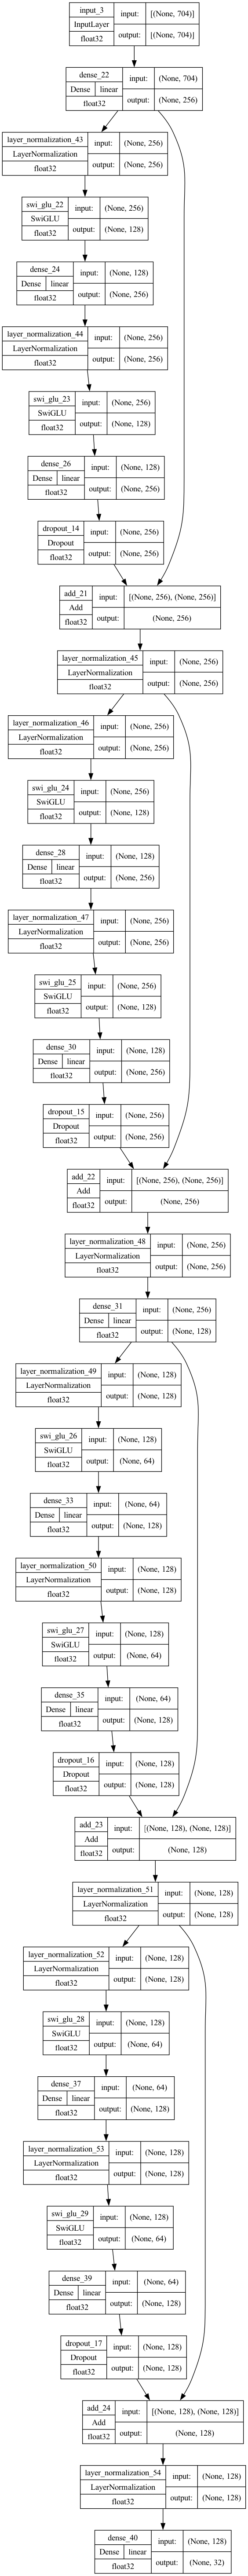

In [11]:
tf.keras.utils.plot_model(C.deep_feature, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [11]:
def find_layer_containing_mha(model, target_name="multi_head_attention_4"):
    for layer in model.layers:
        if hasattr(layer, 'mha') and layer.mha.name == target_name:
            return layer.name
        # If the layer is another model (for nested models), search inside it
        if isinstance(layer, tf.keras.Model):
            result = find_layer_containing_mha(layer, target_name)
            if result:
                return result
    return None

# Search in your base_network
containing_layer_name = find_layer_containing_mha(C.base_network)

if containing_layer_name:
    print(f"multi_head_attention_4 is contained within the layer named: {containing_layer_name}")
else:
    print(f"multi_head_attention_4 was not found in the model.")


multi_head_attention_4 is contained within the layer named: cross_attention


In [12]:
C.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [13]:
C.train_step(data)

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=456.48633>,
 'word_loss': <tf.Tensor: shape=(), dtype=float32, numpy=455.61325>,
 'deep_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7461722>,
 'word_acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'top_5_word_acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [20]:
data = next(it)
x, word_reference = data

In [21]:
pa = C.compute_pair(x)

In [22]:
avg_word_loss, deep_loss = C.compute_loss_pair(pa, word_reference)

In [18]:
word_reference

<tf.RaggedTensor [[343, 408, 3, 135, 1530, 532, 672, 744, 1604, 1635, 670, 647, 361, 1037,
  561, 1610, 1251, 609, 1554, 1251, 1581, 1494, 406, 3, 1530, 1494]      ,
 [758, 273, 318, 208, 391, 1458, 1251, 1216, 661, 835, 976, 915, 730, 1585,
  3, 239, 532, 661, 1494, 207, 1459, 612, 44, 1340, 1565, 820, 915]        ]>

In [ ]:
def compute_loss2(self, inputs, word_reference):
    (student_output, student_deep_feature), (reference_output, reference_deep_feature) = inputs
    # compute the loss for word prediction
    # Cut value to limited range to avoid crazy value of student_output and reference_output
    student_output = tf.clip_by_value(student_output, -15.0, 15.0)
    reference_output = tf.clip_by_value(reference_output, -15.0, 15.0)
    word_loss_student = self.category_loss(word_reference.flat_values, student_output.flat_values)
    word_loss_reference = self.category_loss(word_reference.flat_values, reference_output.flat_values)
    # Cut avg_word_loss to limited range to avoid crazy value
    word_loss_student = tf.clip_by_value(word_loss_student, 0.0, 20.0)
    word_loss_reference = tf.clip_by_value(word_loss_reference, 0.0, 20.0)
    return word_loss_student, word_loss_reference

In [ ]:
compute_loss2(C, pa, word_reference)

In [ ]:
avg_word_loss, deep_loss

In [ ]:
C.auto_balancing_layer.trainable_weights

In [ ]:
C.fit(dst, epochs=1)

In [ ]:
nl = tf.keras.layers.BatchNormalization()

In [ ]:
Ragg1 = tf.RaggedTensor.from_row_splits(tf.random.normal([100,80]), row_splits=tf.range(0, 101, 5))
Ragg2 = tf.RaggedTensor.from_row_splits(tf.random.normal([100,80]), row_splits=tf.range(0, 101, 10))

In [ ]:
tf.ragged.map_flat_values(nl, Ragg2)

In [ ]:
class RaggedBatchNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization(**kwargs)

    def call(self, inputs, training=None, mask=None):
        # Pass `training` and `mask` arguments to the `call` method of the BatchNormalization layer
        return tf.ragged.map_flat_values(
            lambda x: self.batch_norm(x, training=training, mask=mask), inputs
        )

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return super().from_config(config)

In [ ]:
rnl = RaggedBatchNormalization()

In [ ]:
rnl(Ragg1)

In [ ]:
nl(tf.random.normal([100,80]))

In [ ]:
Ragg1.ragged_rank

In [ ]:
Ragg1.flat_values

In [ ]:
data

In [ ]:
dst

In [ ]:
dst = ds.get_batch_data(10)

In [ ]:
dst

In [ ]:
dst, dse = ds.get_batch_data_with_eval(10, 4096, addition_map=unpack)

In [ ]:
dst

In [ ]:
data

In [ ]:
C.deep_feature.output.shape

In [ ]:
w = data[-1]

In [ ]:
C.evaluate(dst)

In [ ]:
# Create a function that can evaluate the database on training data
